In [5]:
import sys
from pathlib import Path
import numpy as np

PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))


import tensorflow as tf
from tensorflow.keras.models import model_from_json

from model.model import Model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
artifacts_dir = "data"

In [7]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import model_from_json
from model.model import Model # Importing your custom Model class

# 1. Define the weighted loss used in training to allow loading
def high_freq_mae(y_true, y_pred):
    frequencies = tf.range(512, dtype=tf.float32)
    weights = 1.0 + (frequencies / 512.0) * 4.0  # 4x weight on high bins
    weights = tf.reshape(weights, (1, 512, 1, 1))
    mae = tf.abs(y_true - y_pred)
    return tf.reduce_mean(mae * weights)

# 2. Paths and Parameters (Matching your v15 specs)
artifacts_dir = "data"
test_file = "ELO_1_raw.wav"
denoised_file = "ELO_1_pred.wav"
params = {
    "sample_rate": 44100,
    "frame_length": 262144,
    "hop_length_frame": 131072, # 50% overlap for smooth reconstruction
    "n_fft": 1023,
    "hop_length_fft": 512,
    "headroom": 1 # Your critical volume fix
}

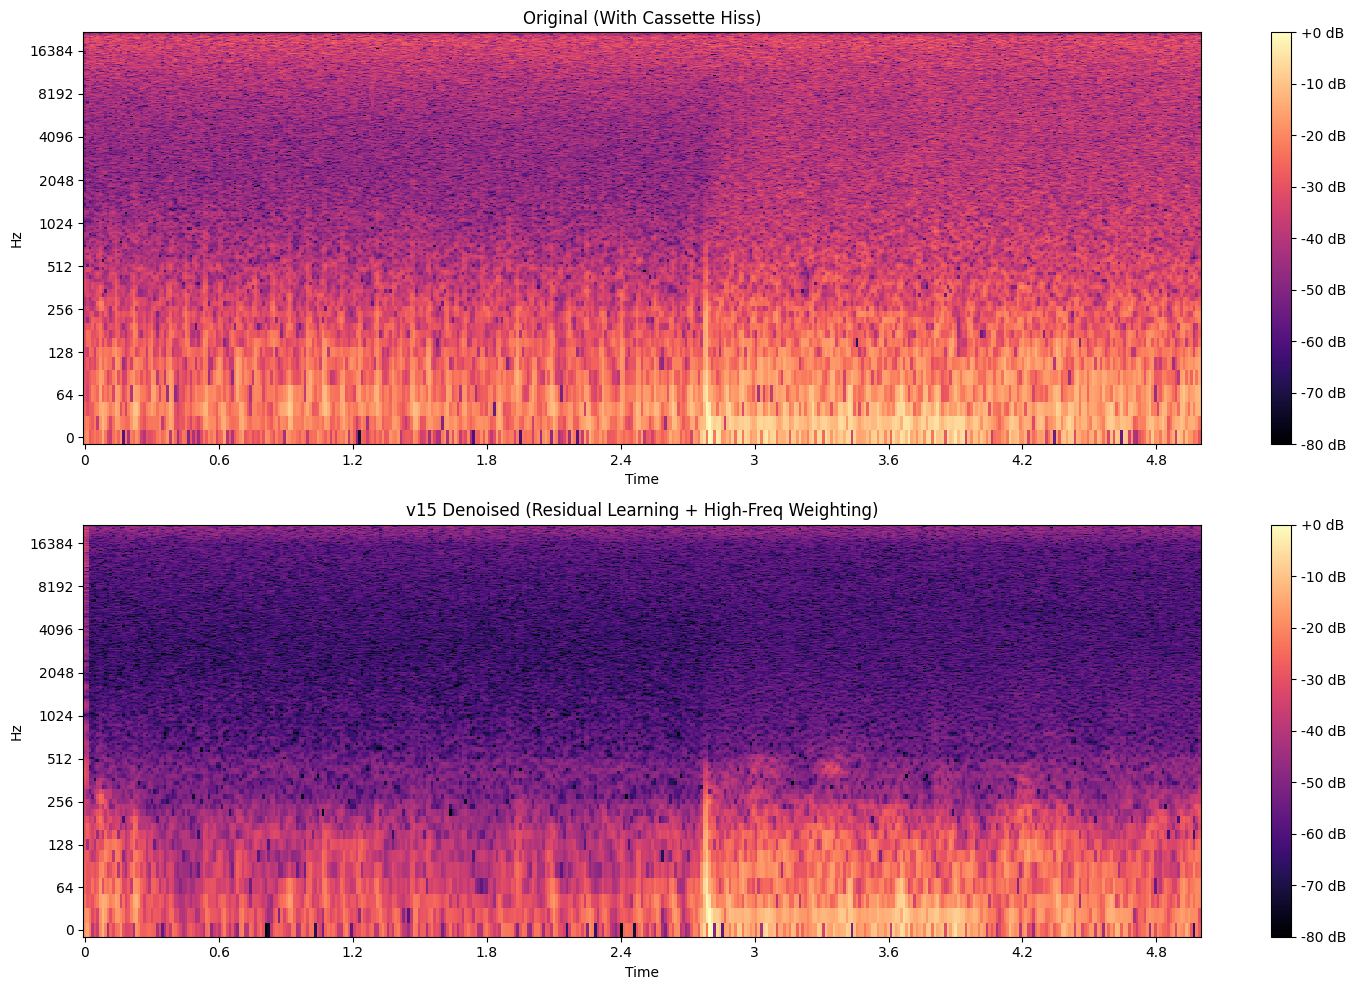

In [8]:
def plot_evaluation(original_path, denoised_path):
    y_orig, _ = librosa.load(original_path, sr=params['sample_rate'])
    y_denoise, _ = librosa.load(denoised_path, sr=params['sample_rate'])
    
    plt.figure(figsize=(15, 10))
    
    # Spectrogram Comparison
    plt.subplot(2, 1, 1)
    S_orig = librosa.amplitude_to_db(np.abs(librosa.stft(y_orig[:44100*5])), ref=np.max)
    librosa.display.specshow(S_orig, sr=params['sample_rate'], y_axis='log', x_axis='time')
    plt.title("Original (With Cassette Hiss)")
    plt.colorbar(format='%+2.0f dB')
    
    plt.subplot(2, 1, 2)
    S_denoise = librosa.amplitude_to_db(np.abs(librosa.stft(y_denoise[:44100*5])), ref=np.max)
    librosa.display.specshow(S_denoise, sr=params['sample_rate'], y_axis='log', x_axis='time')
    plt.title("v15 Denoised (Residual Learning + High-Freq Weighting)")
    plt.colorbar(format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()

plot_evaluation(f"{artifacts_dir}/{test_file}", f"{artifacts_dir}/{denoised_file}")

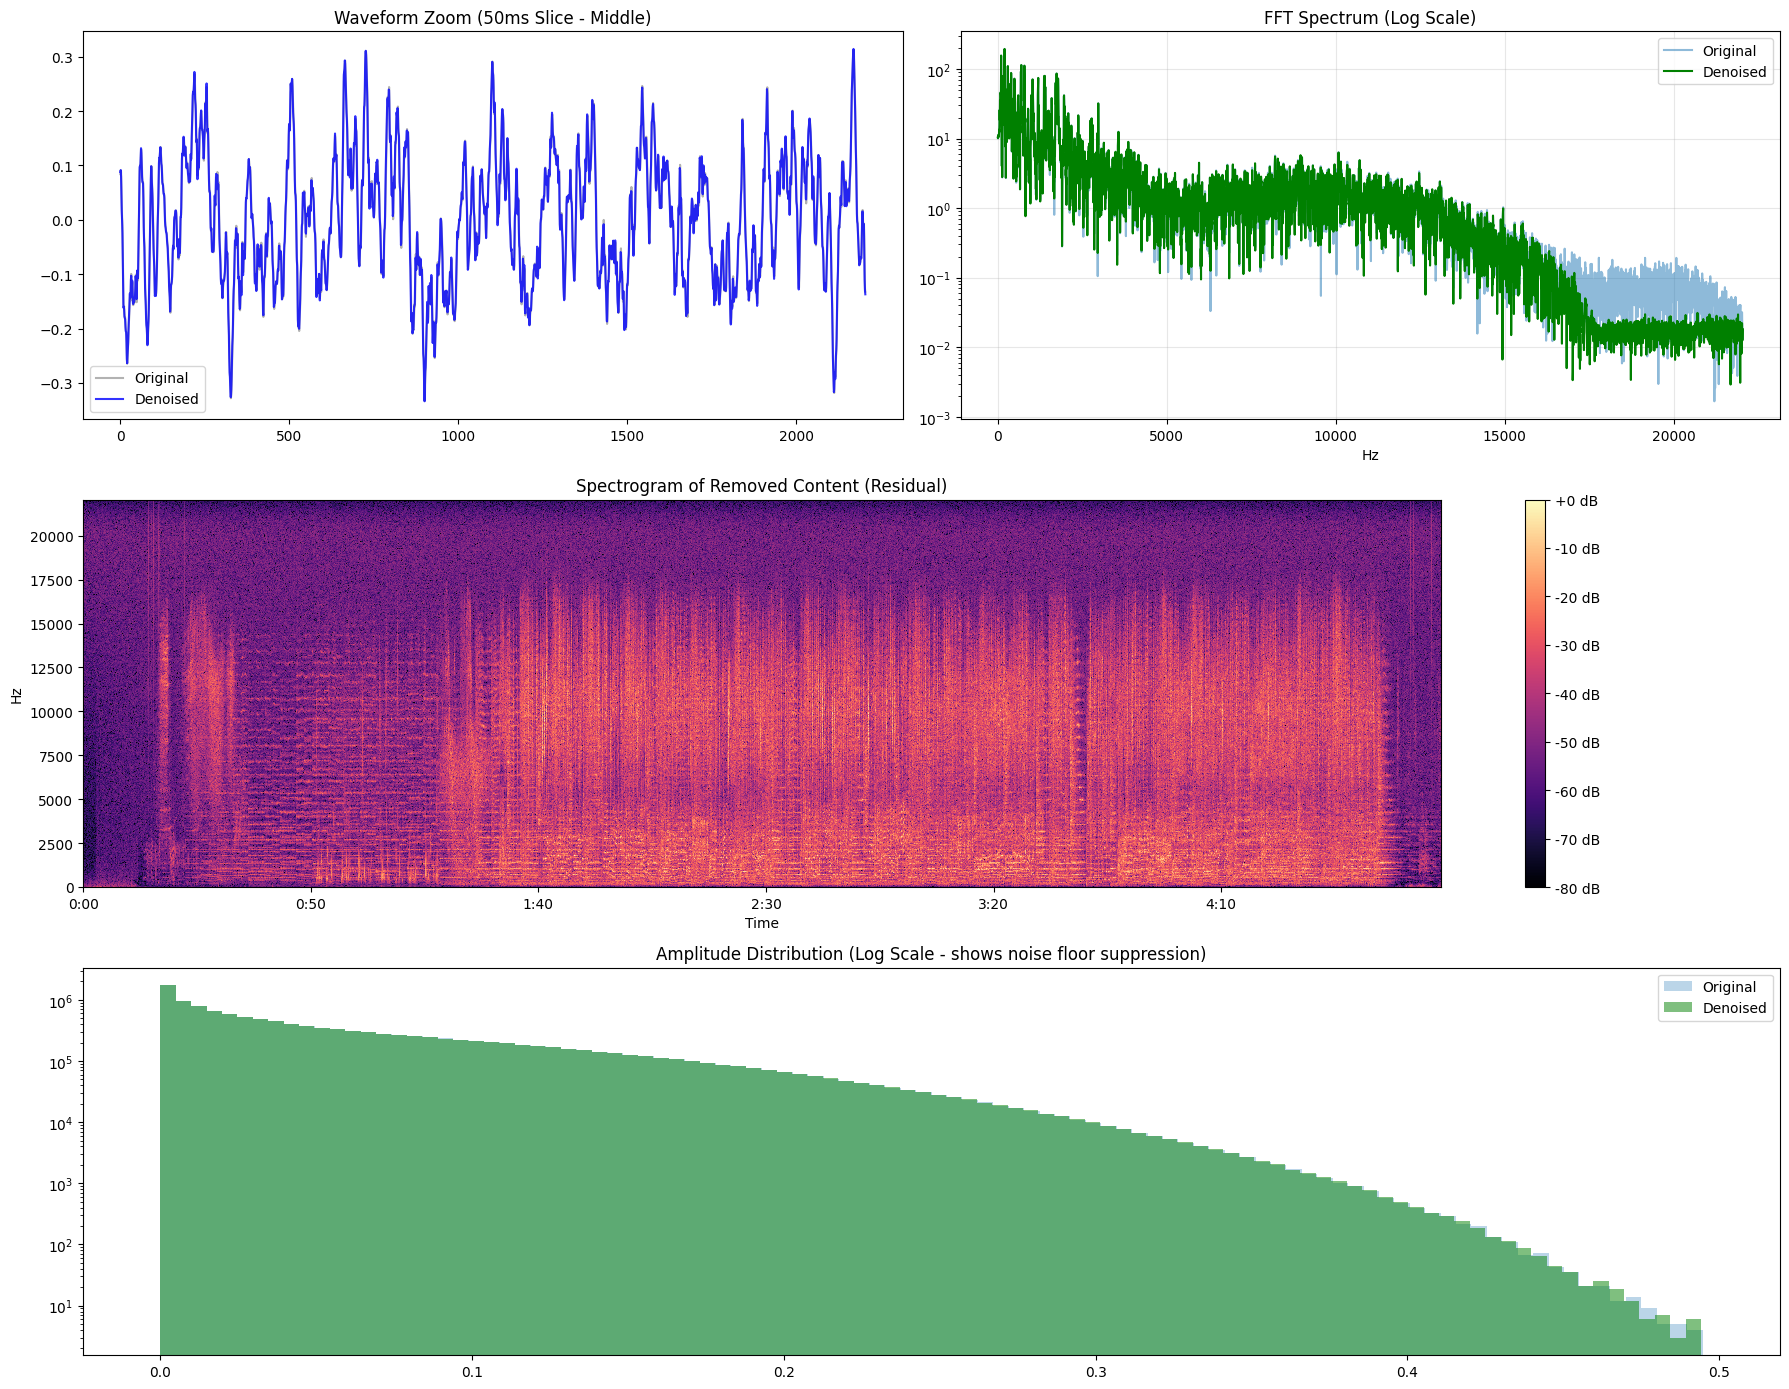


V15 MODEL EVALUATION SUMMARY
        Label      RMS     Peak  Std Dev          Mean  dBFS (RMS)  dBFS (Peak)  P95 Floor  P99 Floor
     Original 0.094373 0.494781 0.094373  1.994707e-09  -20.503042    -6.111732   0.203247   0.276138
   v15 Result 0.094424 0.494171 0.094424 -1.534607e-05  -20.498310    -6.122453   0.203339   0.276367
Removed Noise 0.007925 0.085190 0.007925  1.534807e-05  -42.019470   -21.392248   0.016937   0.025116

RMS Reduction: -0.00 dB
Signal-to-Noise Improvement Ratio: 1.00x


In [9]:
import pandas as pd
from scipy.fft import fft, fftfreq

def get_dbfs(rms_val):
    return 20 * np.log10(rms_val + 1e-9)

def analyze_audio_v15(original_path, denoised_path):
    # Load full files
    y_orig, _ = librosa.load(original_path, sr=params['sample_rate'])
    y_denoised, _ = librosa.load(denoised_path, sr=params['sample_rate'])
    
    # Ensure equal length for difference analysis
    min_len = min(len(y_orig), len(y_denoised))
    y_orig, y_denoised = y_orig[:min_len], y_denoised[:min_len]
    
    # 1. Difference Signal (The Hiss captured by the model)
    y_diff = y_orig - y_denoised
    
    def get_stats(signal, label):
        rms = np.sqrt(np.mean(signal**2))
        peak = np.max(np.abs(signal))
        return {
            "Label": label,
            "RMS": rms,
            "Peak": peak,
            "Std Dev": np.std(signal),
            "Mean": np.mean(signal),
            "dBFS (RMS)": get_dbfs(rms),
            "dBFS (Peak)": get_dbfs(peak),
            "P95 Floor": np.percentile(np.abs(signal), 95),
            "P99 Floor": np.percentile(np.abs(signal), 99)
        }

    stats_orig = get_stats(y_orig, "Original")
    stats_denoised = get_stats(y_denoised, "v15 Result")
    stats_diff = get_stats(y_diff, "Removed Noise")
    
    # 2. Visualisation Suite
    plt.figure(figsize=(18, 14))
    
    # A. Waveform Zoom (Middle of file)
    plt.subplot(3, 2, 1)
    mid = len(y_orig) // 2
    zoom_samples = int(0.05 * params['sample_rate']) # 50ms zoom
    plt.plot(y_orig[mid:mid+zoom_samples], label="Original", alpha=0.6, color='gray')
    plt.plot(y_denoised[mid:mid+zoom_samples], label="Denoised", color='blue', alpha=0.8)
    plt.title("Waveform Zoom (50ms Slice - Middle)")
    plt.legend()

    # B. FFT Spectrum (Comparison of Frequency Response)
    plt.subplot(3, 2, 2)
    N = 8192
    xf = fftfreq(N, 1/params['sample_rate'])[:N//2]
    yf_orig = np.abs(fft(y_orig[mid:mid+N]))[:N//2]
    yf_denoised = np.abs(fft(y_denoised[mid:mid+N]))[:N//2]
    plt.semilogy(xf, yf_orig, label="Original", alpha=0.5)
    plt.semilogy(xf, yf_denoised, label="Denoised", color='green')
    plt.title("FFT Spectrum (Log Scale)")
    plt.xlabel("Hz")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # C. Spectrogram of the REMOVED signal
    plt.subplot(3, 1, 2)
    D_diff = librosa.amplitude_to_db(np.abs(librosa.stft(y_diff)), ref=np.max)
    librosa.display.specshow(D_diff, sr=params['sample_rate'], x_axis='time', y_axis='hz')
    plt.title("Spectrogram of Removed Content (Residual)")
    plt.colorbar(format='%+2.0f dB')

    # D. Amplitude Percentile Distribution (Noise Floor Analysis)
    plt.subplot(3, 1, 3)
    plt.hist(np.abs(y_orig), bins=100, alpha=0.3, label="Original", log=True)
    plt.hist(np.abs(y_denoised), bins=100, alpha=0.5, label="Denoised", color='green', log=True)
    plt.title("Amplitude Distribution (Log Scale - shows noise floor suppression)")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # Summary DataFrame
    df = pd.DataFrame([stats_orig, stats_denoised, stats_diff])
    
    print("\n" + "="*50)
    print("V15 MODEL EVALUATION SUMMARY")
    print("="*50)
    print(df.to_string(index=False))
    
    # Key Success Indicators
    reduction = stats_orig['dBFS (RMS)'] - stats_denoised['dBFS (RMS)']
    ratio = stats_orig['RMS'] / stats_denoised['RMS']
    print(f"\nRMS Reduction: {reduction:.2f} dB")
    print(f"Signal-to-Noise Improvement Ratio: {ratio:.2f}x")
    
    if stats_diff['Peak'] > 0.5:
        print("WARNING: Removed signal has high peak. Check for music 'ghosting' in the residual.")

# Execute Analysis
analyze_audio_v15(f"{artifacts_dir}/{test_file}", f"{artifacts_dir}/{denoised_file}")